In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


In [2]:
n = 80

arr = torch.load('data/TTBAR/ttbar_1_greater_0_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'data/TTBAR/ttbar_{int(n+2)}_greater_0_sim')])



In [3]:
dt_1 = []
dt_2 = []
dt_3 = []

for a in arr:
    
    if a[-4].item() ==0.: 
        dt_1.append(a)
    elif a[-4].item() ==1.0: 
        dt_2.append(a)
    else:
        dt_3.append(a)
    
dt_1 = torch.vstack(dt_1).float()
dt_2 = torch.vstack(dt_2).float()   
dt_3 = torch.vstack(dt_3).float()   

In [4]:
print(f'{len(dt_1)} wafers of type 0')
print(f'mean calcq: {torch.mean(dt_1[:,0:48])}')
print(f'std calcq: {torch.std(dt_1[:,0:48])}')
mean_dt_1 = torch.mean(dt_1[:,0:48])
std_dt_1 = torch.std(dt_1[:,0:48])

432654 wafers of type 0
mean calcq: 27.600881576538086
std calcq: 51.770050048828125


In [5]:
dt_1[:,0:48] = (dt_1[:,0:48] - torch.mean(dt_1[:,0:48]))/torch.std(dt_1[:,0:48])
dt_2[:,0:48] = (dt_2[:,0:48] - torch.mean(dt_2[:,0:48]))/torch.std(dt_2[:,0:48])
dt_3[:,0:48] = (dt_3[:,0:48] - torch.mean(dt_3[:,0:48]))/torch.std(dt_3[:,0:48])

In [6]:
def AE_MSE(data,pred):
    return torch.mean(torch.sum((data-pred)**2,dim=1))

def AE_MAE(data,pred):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))

def weighted_AE_MSE(data, pred):
    return torch.mean(torch.sum((data[:,0:48])**2,dim=1)*torch.sum((data-pred)**2,dim=1))

def dif_weighted_AE_MSE(data, pred,alpha = 0.25):
    return torch.mean(((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def log_dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(torch.log((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def calcQ_Error(data,pred, mean,std):
    return torch.mean(torch.sum(torch.abs(pred-pred),dim=1))*std+mean
    
def std_error(data,pred):
    return torch.mean(torch.sum(torch.abs(torch.subtract(data,pred)),dim=1))

def new_loss(data,pred,epoch,cut = 10):
    #Reconstruction
    error = dif_weighted_AE_MSE(data,pred)
    if epoch < cut:
        return error + std_error(data,pred)
    else:
        #Energy Conservation
        sum_dt, sum_pred = torch.sum(data, dim=1), torch.sum(pred,dim=1)
        sum_error = torch.sum(torch.norm(sum_dt-sum_pred))
        

        return  error +std_error(data,pred)+ torch.log(calcQ_Error(data,pred,mean_dt_1,std_dt_1))+ 0.5*sum_error*np.min([(epoch-cut)/cut,1])

In [7]:
num_epochs =100
lr = 0.00045
loss =new_loss

In [8]:

size_train =50000
size_test = 30000

train_raw = dt_1[0:size_train,0:48]
test_raw = dt_1[-size_test:,0:48]

model_1 = torch.load('models/dt_1_greater_0_250_100_dif')
test = model_1(test_raw).detach()
train_out =model_1(train_raw).detach()


# train = torch.vstack([train,largest[0:1000]] )
train=train_raw[torch.randperm(train_raw.size()[0])]
# test=test_out[torch.randperm(test_out.size()[0])]
train_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=50,
    shuffle=False
)


In [77]:
train_raw

tensor([[-0.4559, -0.5331, -0.3013,  ..., -0.5331, -0.5331, -0.4559],
        [-0.5331, -0.4559, -0.5331,  ..., -0.5331, -0.5331, -0.5331],
        [-0.5331,  1.0122, -0.4559,  ..., -0.5331, -0.5331, -0.5331],
        ...,
        [-0.2241, -0.5331,  0.2781,  ..., -0.5331, -0.5331, -0.5331],
        [-0.1661, -0.1661, -0.4752,  ..., -0.5331, -0.3786, -0.3979],
        [-0.5331, -0.2820, -0.3786,  ..., -0.5331, -0.5331, -0.4172]])

In [78]:
train_out

tensor([[-0.2208, -0.3357, -0.2614,  ..., -0.2583, -0.3224, -0.4496],
        [-0.2939, -0.4651, -0.4017,  ..., -0.2254, -0.4328, -0.2286],
        [-0.1304,  1.1782, -0.2088,  ..., -0.2751, -0.1759, -0.1401],
        ...,
        [-0.5685, -0.5331, -0.1188,  ..., -0.4219, -0.4860, -0.7355],
        [-0.3579, -0.4384, -0.3234,  ..., -0.4520, -0.5740, -0.3600],
        [-0.4401, -0.2719, -0.3679,  ..., -0.4901, -0.4227, -0.4470]])

Epoch 0, lr 0.00045
Epoch 0: Train 440.992432636261, Test 358.8353271484375
Epoch 1, lr 0.00045
Epoch 1: Train 347.0092451438904, Test 294.2597351074219
Epoch 2, lr 0.00045
Epoch 2: Train 291.9906473884582, Test 251.798095703125
Epoch 3, lr 0.00045
Epoch 3: Train 252.4784428100586, Test 219.09532165527344
Epoch 4, lr 0.00045
Epoch 4: Train 220.55573866271973, Test 191.62669372558594
Epoch 5, lr 0.00045
Epoch 5: Train 193.2566374206543, Test 167.751953125
Epoch 6, lr 0.00045
Epoch 6: Train 169.45218420791625, Test 146.8270721435547
Epoch 7, lr 0.00045
Epoch 7: Train 148.62326206016542, Test 128.50387573242188
Epoch 8, lr 0.00045
Epoch 8: Train 130.43703901672365, Test 112.52265930175781
Epoch 9, lr 0.00045
Epoch 9: Train 114.62361246871949, Test 98.65290832519531
Epoch 10, lr 0.00045
Epoch 10: Train 104.22393284225464, Test 89.95560455322266
Epoch 11, lr 0.00045
Epoch 11: Train 92.98764123725891, Test 92.83072662353516
Epoch 12, lr 0.00045
Epoch 12: Train 83.06624991798401, Test 87.0800

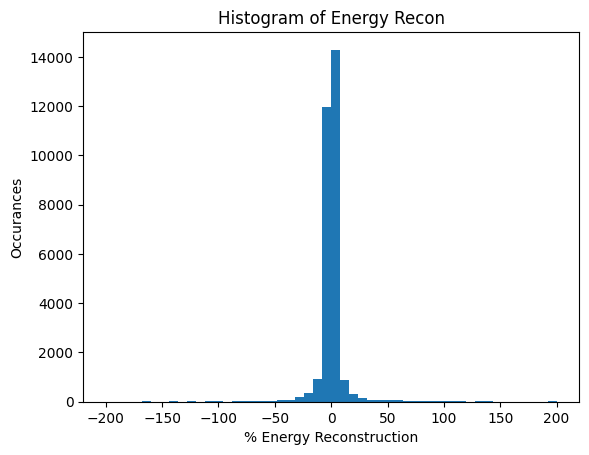

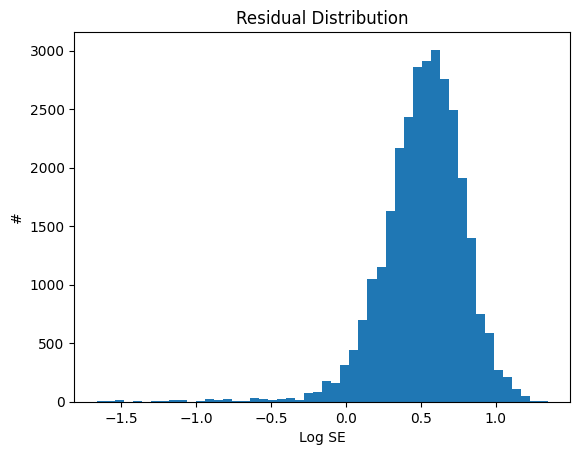

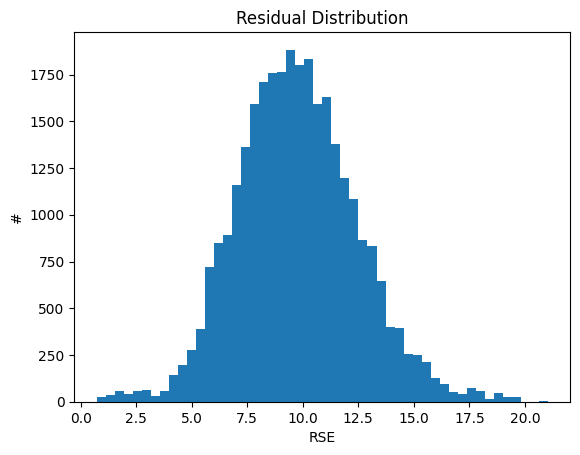

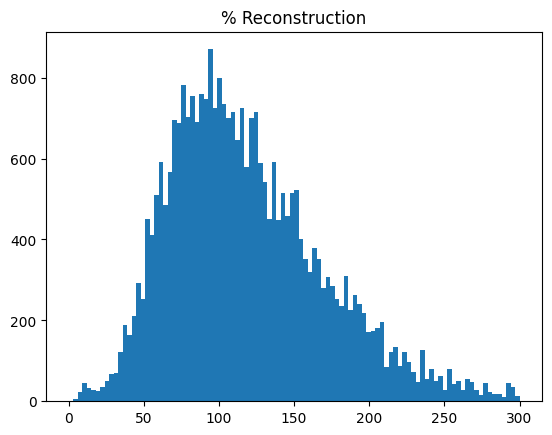

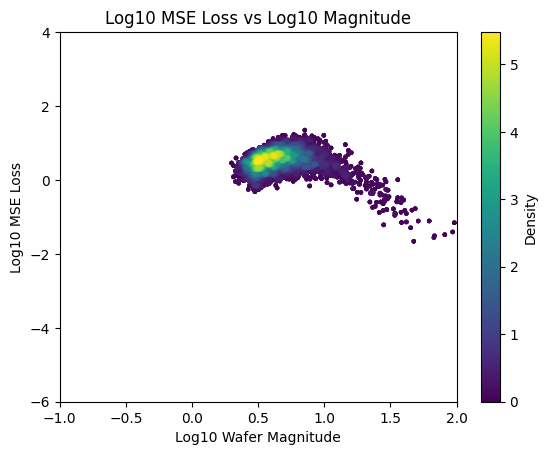

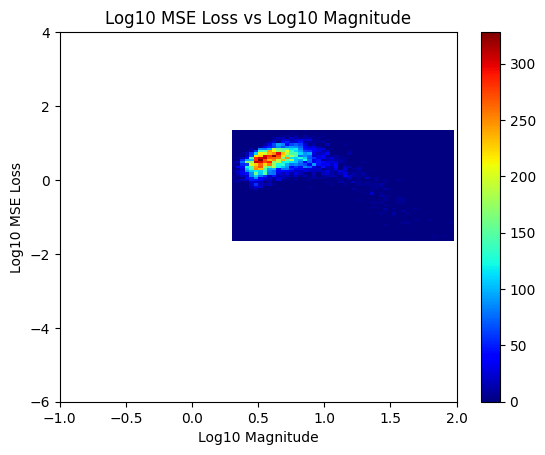

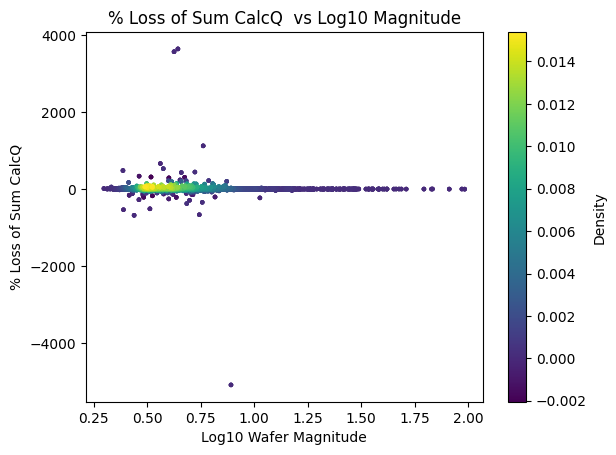

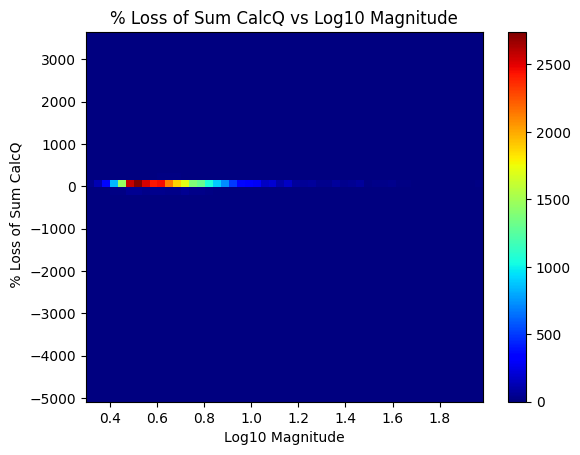

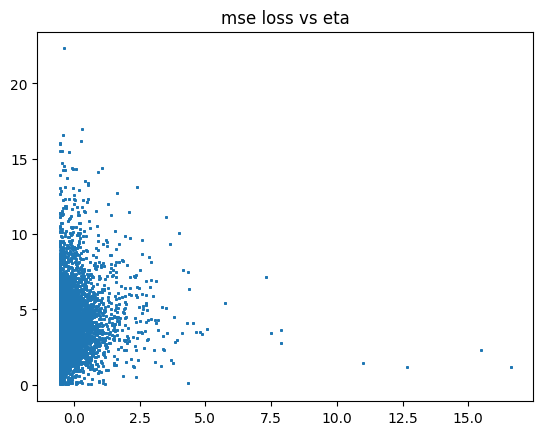

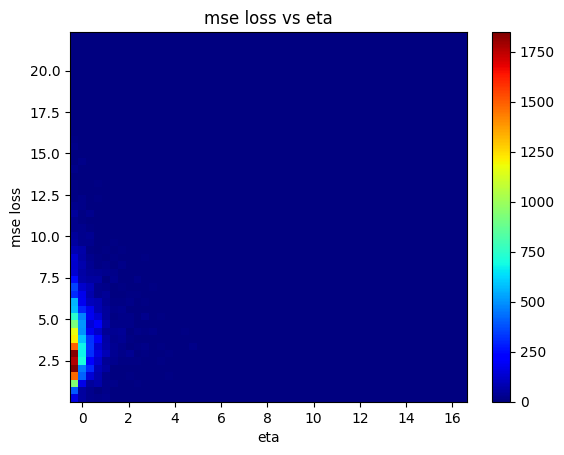

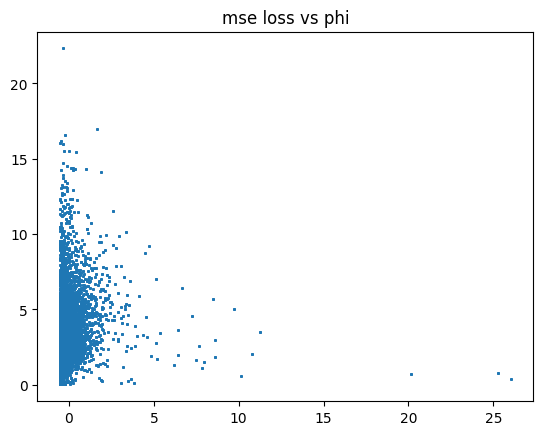

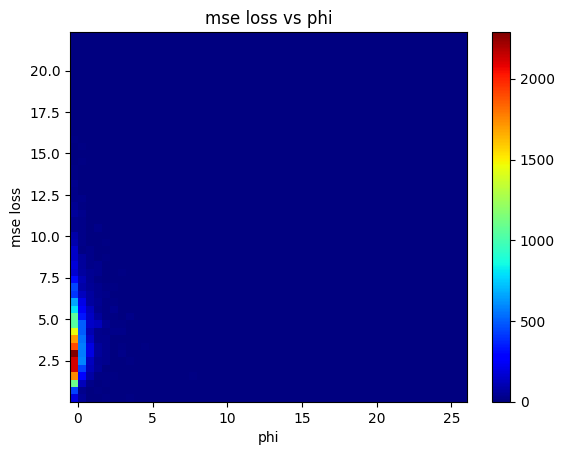

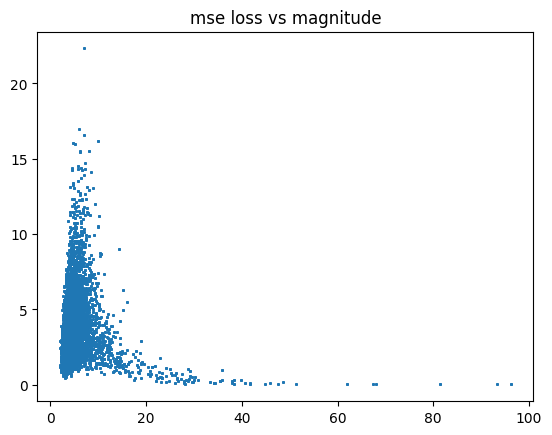

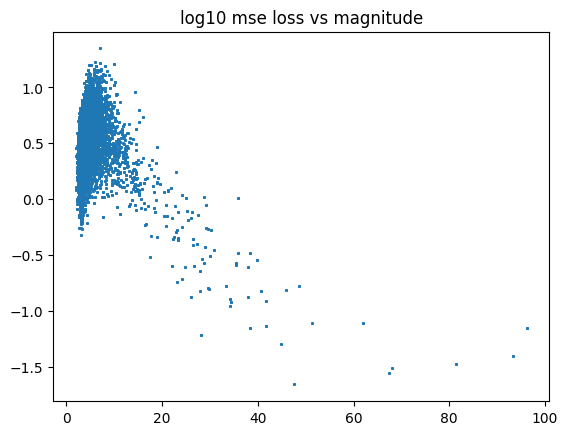

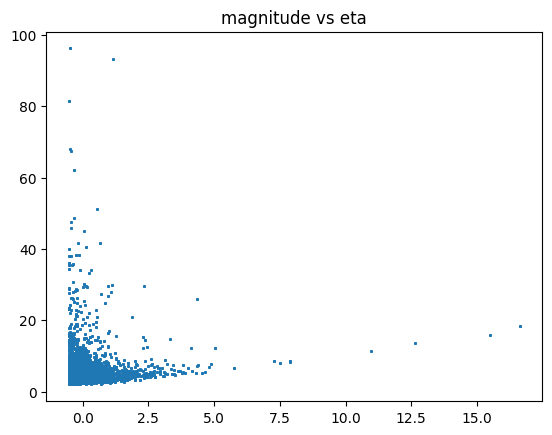

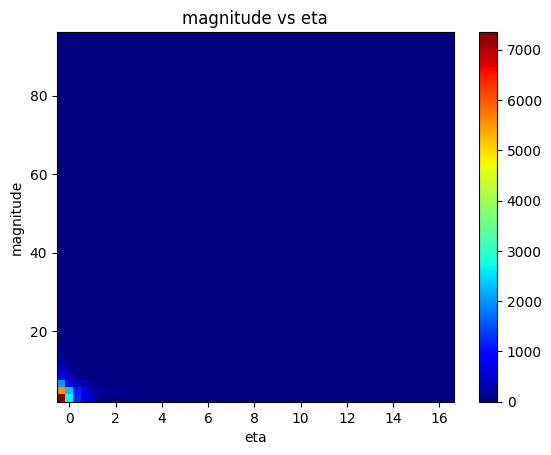

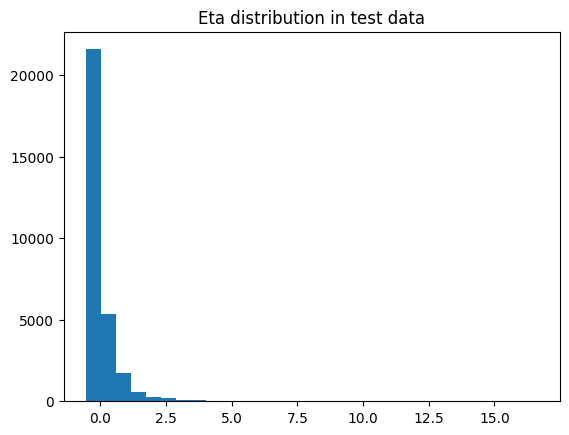

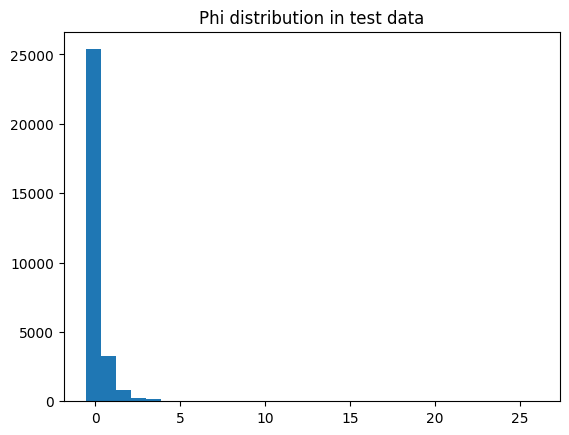

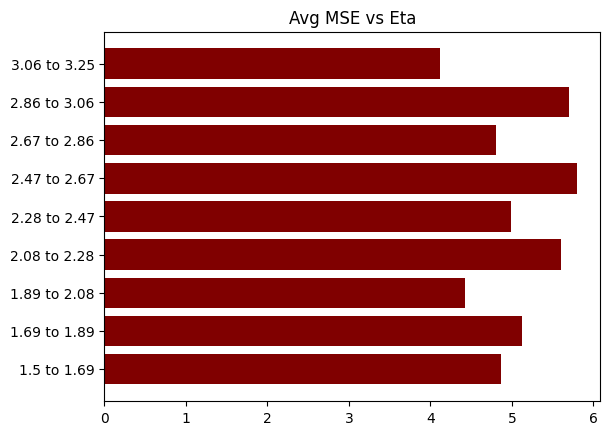

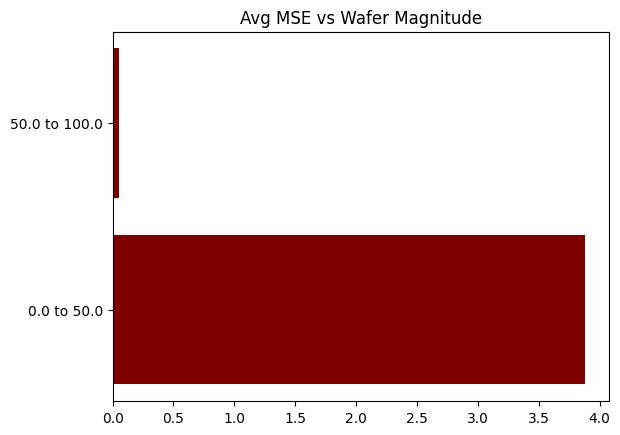

tensor([[-0.5331, -0.5331,  3.2240,  1.2009,  5.6158],
        [-0.2627, -0.5331,  3.1752,  3.2277,  9.4010],
        [-0.3400, -0.4172,  7.9818,  1.8895,  6.7632],
        ...,
        [-0.1468, -0.3979,  3.5652,  1.3919,  5.9257],
        [-0.5331, -0.4752,  4.1339,  6.8406, 14.3957],
        [-0.3013,  0.2009,  3.0976,  1.8819,  6.8326]], grad_fn=<CatBackward0>)

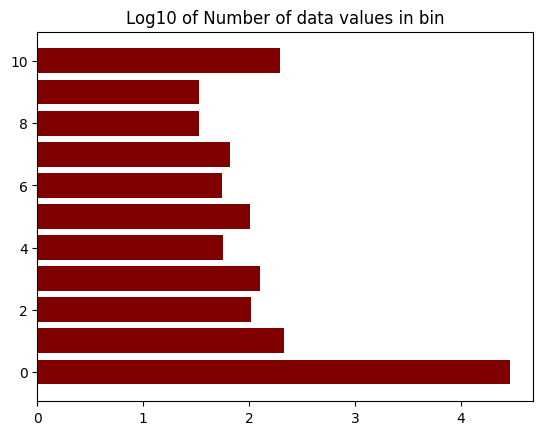

In [9]:
# fine-tune autoencoder
#batch 500

perm = nn.Sequential(nn.Linear(48,48))


optimizer = optim.Adam(perm.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []

# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        perm.train()
        data = data_list[0]
        mod_out = model_1(data).detach()
        v_pred = perm(mod_out)
        
        batch_loss = loss(data, v_pred,epoch) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    perm.eval()
    test_pred = perm(data_test)
    batch_test = loss(test_raw, test_pred,epoch)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
perm.eval()
AE_Stats.gen_all_stats(perm(test),test_raw,test_raw)


In [50]:
perm(test)[0]-test_raw

tensor([[ 0.3538, -0.0800, -0.1830,  ..., -1.4760,  0.1601,  0.2674],
        [-0.5540,  0.3256, -0.3569,  ...,  0.2045,  0.5464, -0.8722],
        [-0.0132,  0.0552, -0.8011,  ...,  0.5522,  0.5271, -0.2348],
        ...,
        [ 0.4504,  0.4029,  0.2226,  ...,  0.5522,  0.1987,  0.2095],
        [ 0.1220,  0.2290, -0.6466,  ..., -0.3363,  0.5850,  0.2867],
        [-0.3609,  0.2677,  0.1647,  ...,  0.4750,  0.3532, -0.3893]],
       grad_fn=<SubBackward0>)

In [51]:
test-model_1(test_raw)

tensor([[ 0.2715,  0.2041,  0.1135,  ..., -1.4403, -0.1988, -0.0480],
        [-0.6588,  0.0936,  2.2631,  ...,  0.0330,  0.0204, -0.9900],
        [ 0.2182,  0.0786,  0.3479,  ..., -0.1554, -0.1074, -0.2683],
        ...,
        [-0.0235,  0.1385,  0.2107,  ...,  0.3158,  0.4154,  0.2198],
        [ 0.2232,  0.2011, -0.5895,  ..., -0.2048,  0.3672,  0.2013],
        [-0.3234,  0.1400,  0.1348,  ...,  0.2282,  0.0798, -0.4998]],
       grad_fn=<SubBackward0>)

In [47]:
test_raw

tensor([[-0.4366, -0.0502, -0.0502,  ...,  1.4951, -0.1082, -0.4559],
        [ 0.4713, -0.4559,  0.1236,  ..., -0.1855, -0.4945,  0.6838],
        [-0.0696, -0.1855,  0.5679,  ..., -0.5331, -0.4752,  0.0463],
        ...,
        [-0.5331, -0.5331, -0.4559,  ..., -0.5331, -0.1468, -0.3979],
        [-0.2048, -0.3593,  0.4133,  ...,  0.3554, -0.5331, -0.4752],
        [ 0.2781, -0.3979, -0.3979,  ..., -0.4559, -0.3013,  0.2009]])

In [42]:
test_raw

tensor([[-0.4366, -0.0502, -0.0502,  ...,  1.4951, -0.1082, -0.4559],
        [ 0.4713, -0.4559,  0.1236,  ..., -0.1855, -0.4945,  0.6838],
        [-0.0696, -0.1855,  0.5679,  ..., -0.5331, -0.4752,  0.0463],
        ...,
        [-0.5331, -0.5331, -0.4559,  ..., -0.5331, -0.1468, -0.3979],
        [-0.2048, -0.3593,  0.4133,  ...,  0.3554, -0.5331, -0.4752],
        [ 0.2781, -0.3979, -0.3979,  ..., -0.4559, -0.3013,  0.2009]])

MSE 3.8743984699249268
Median 3.4472317695617676
Standard Devitaion 2.2214508056640625
Average std error 9.75352668762207
Average % Error of Energy Reconstruction 9.208294868469238


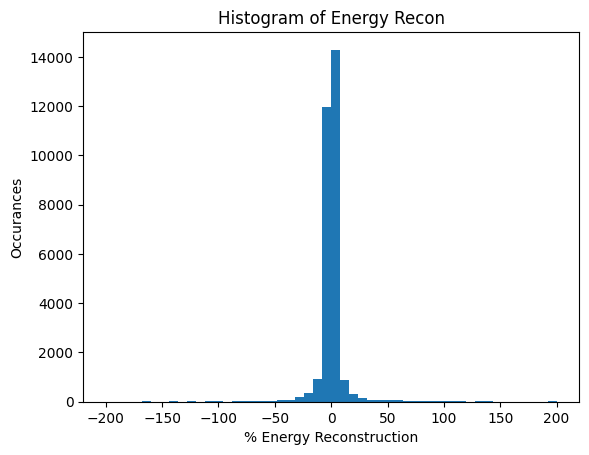

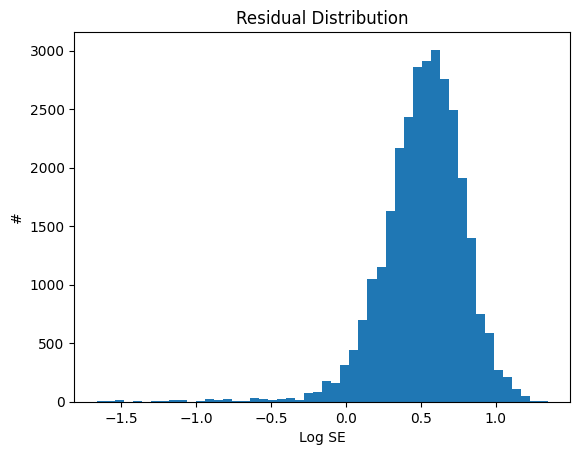

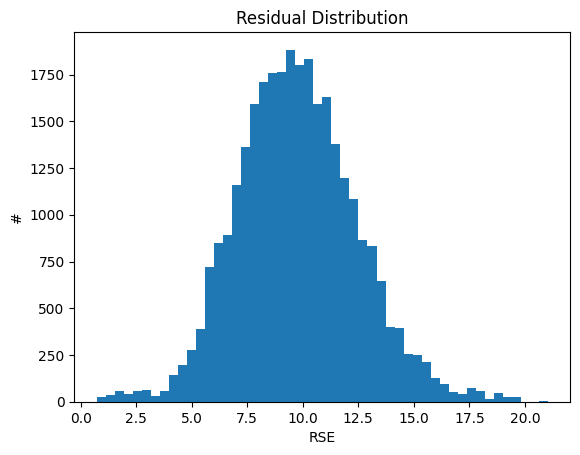

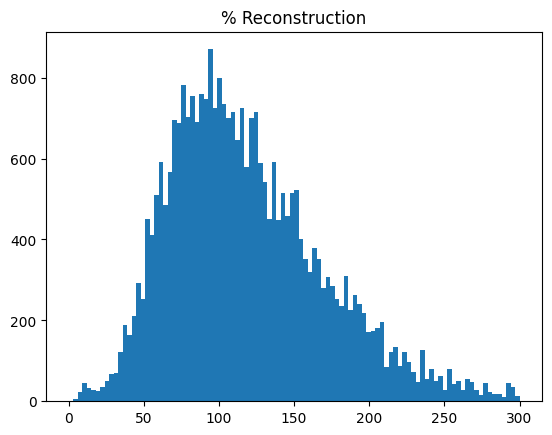

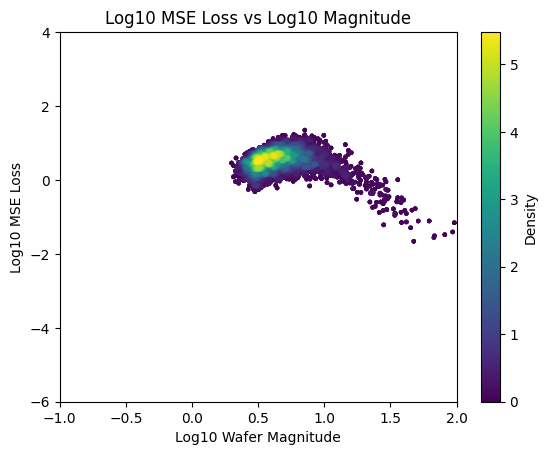

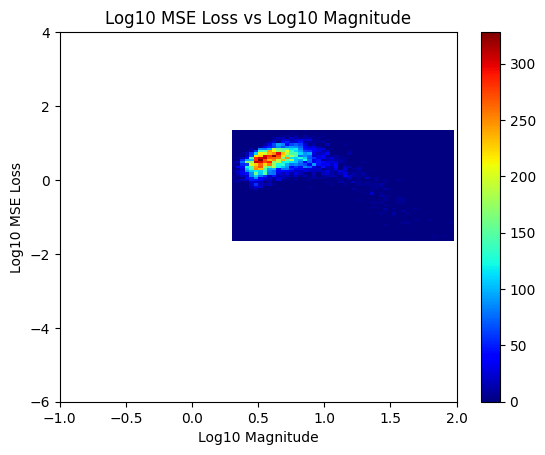

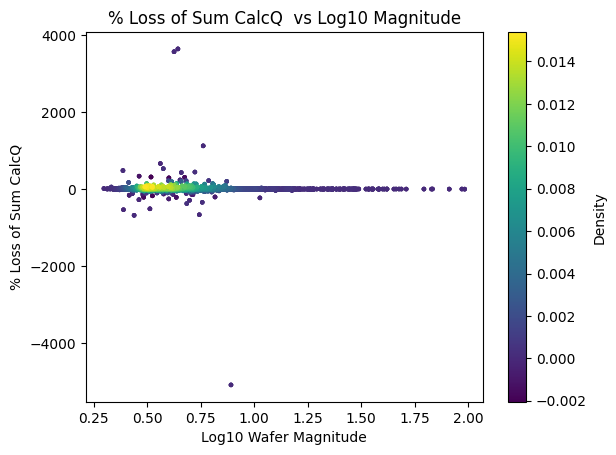

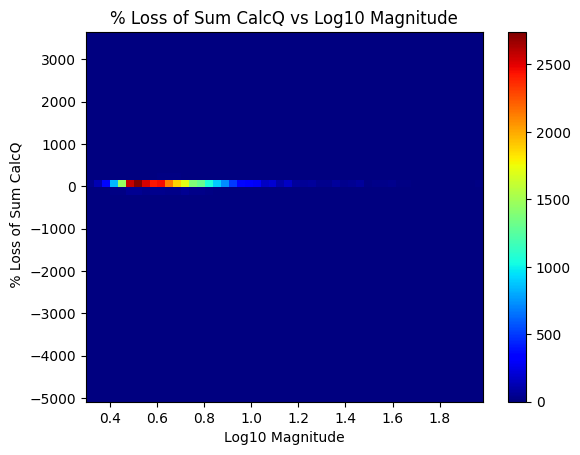

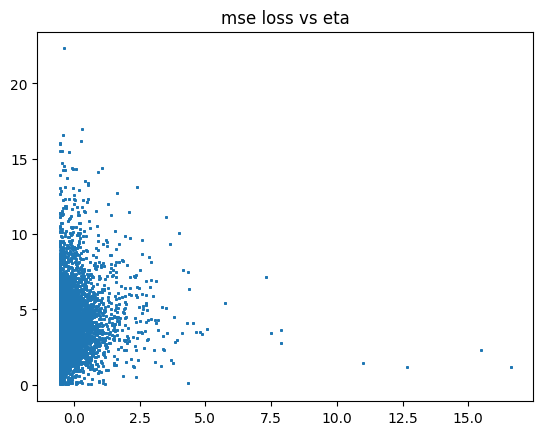

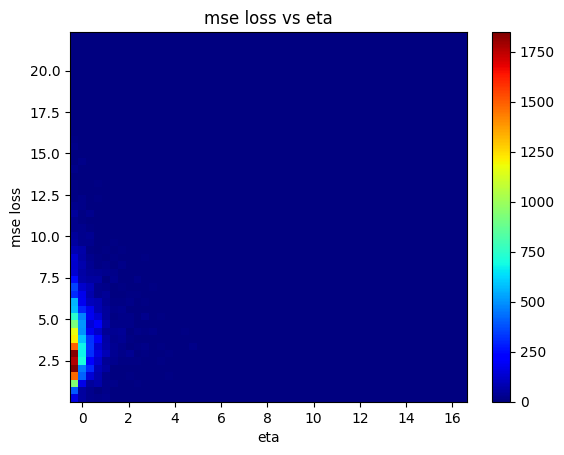

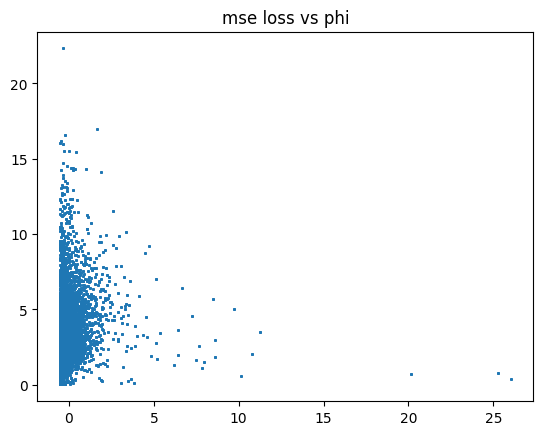

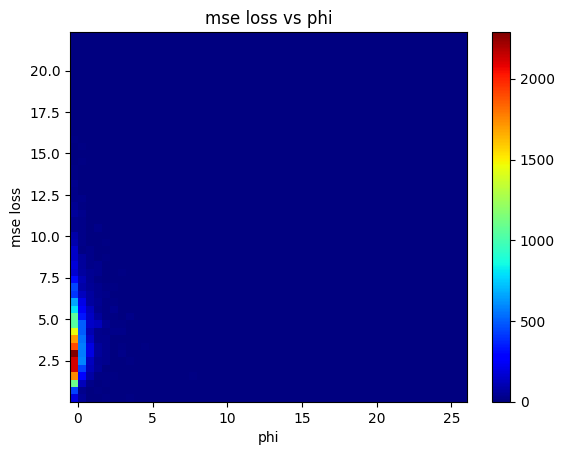

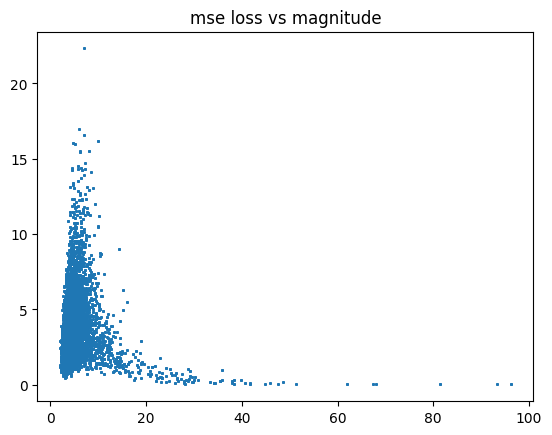

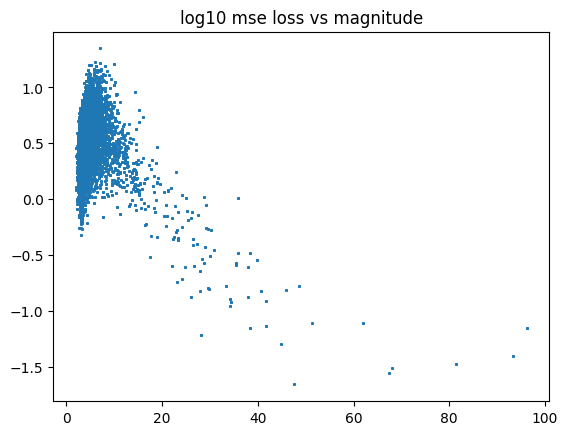

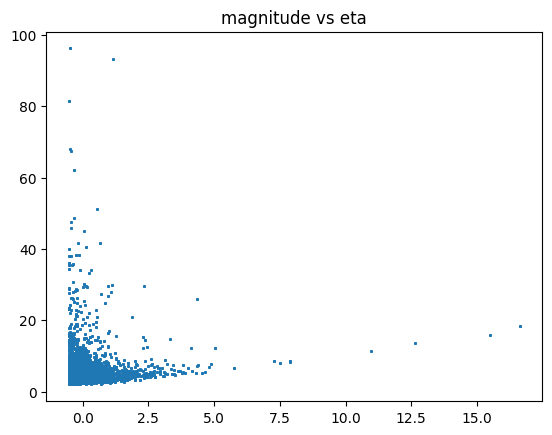

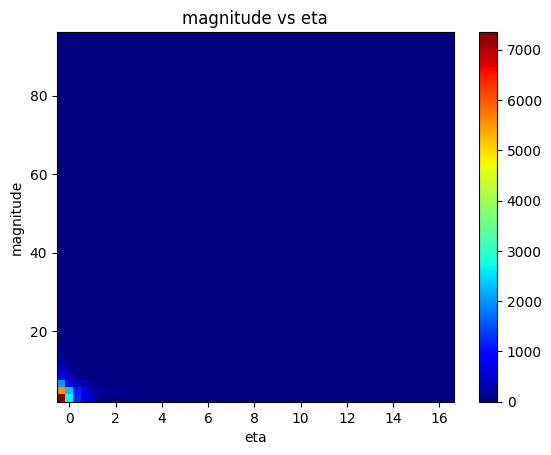

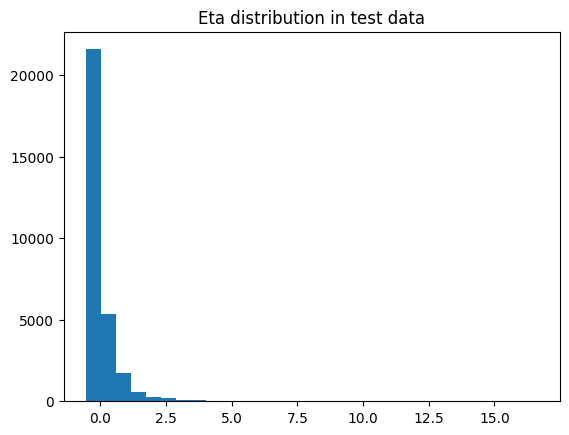

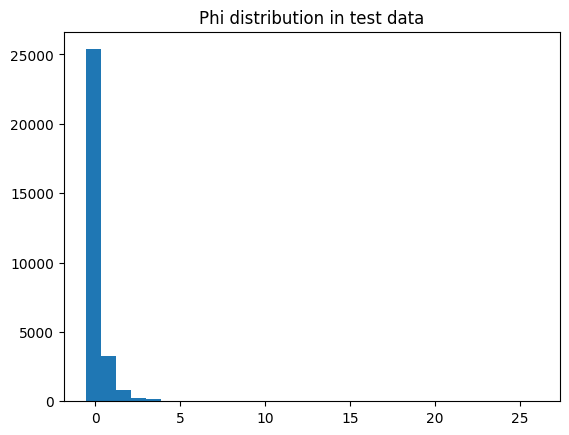

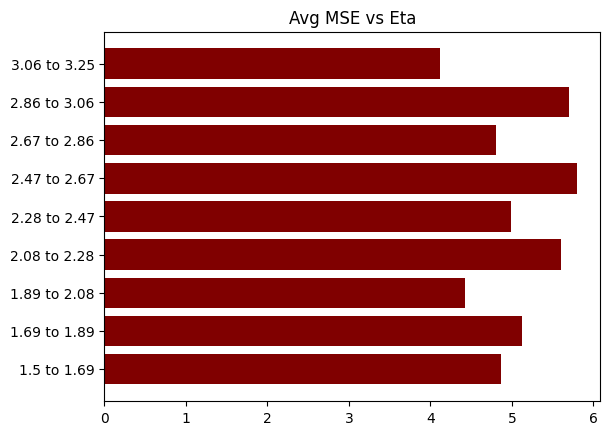

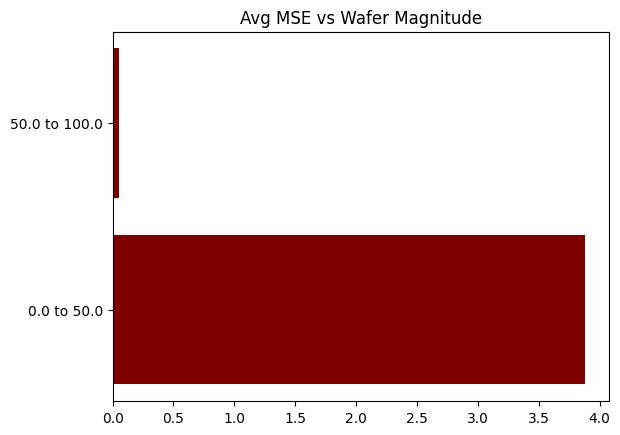

tensor([[-0.5331, -0.5331,  3.2240,  1.2009,  5.6158],
        [-0.2627, -0.5331,  3.1752,  3.2277,  9.4010],
        [-0.3400, -0.4172,  7.9818,  1.8895,  6.7632],
        ...,
        [-0.1468, -0.3979,  3.5652,  1.3919,  5.9257],
        [-0.5331, -0.4752,  4.1339,  6.8406, 14.3957],
        [-0.3013,  0.2009,  3.0976,  1.8819,  6.8326]], grad_fn=<CatBackward0>)

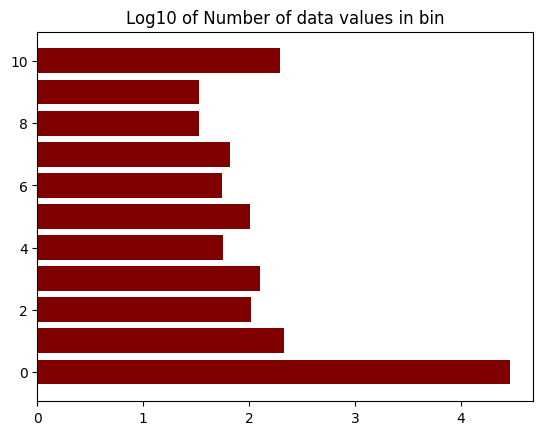

In [10]:
AE_Stats.gen_all_stats(perm(model_1(test_raw).detach()),test_raw,test_raw)